In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import  nn

from src.face_segmentation_dataset import *
from src.models import UNET
from src.utils import *

plt.ion()   # interactive mode
DATA_FOLDER = 'V2' # data in V2 folder 

# 1. Load train and test dataloaders

In [2]:
trainset = FacialSegmentationDataset(root_dir=DATA_FOLDER,
                                     train=True,
                                     transform=transforms.Compose([
                                               Resize((128,128)),
                                               MaskToLabel(),
                                               ToTensor(),
                                               ]))

trainloader = data.DataLoader(trainset, batch_size=5, shuffle=True)

testset = FacialSegmentationDataset(root_dir=DATA_FOLDER, 
                                    train=False, 
                                    transform=transforms.Compose([
                                               Resize((128,128)),
                                               MaskToLabel(),
                                               ToTensor(),
                                               ]))

testloader = data.DataLoader(testset, batch_size=4, shuffle=False)

# 2. Define the training loop

In [3]:
# train loop

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

def train(model, 
          train_dl, 
          valid_dl, 
          loss_fn, 
          optimizer, 
          acc_fn, 
          epochs=15,
          verbose=False):
    
    model.to(device)

    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []

    for epoch in tqdm(range(epochs)):
        if verbose:
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.to(device)
                y = y.to(device)
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y.long())

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 


            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)
        
            if verbose:
                print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
            train_acc.append(epoch_acc) if phase=='train' else valid_acc.append(epoch_acc)

    return train_loss, valid_loss, train_acc, valid_acc  

def pixel_accuracy(y_pred, y_test):
    return (y_pred.argmax(dim=1) == y_test.to(device)).float().mean()

# metrics to use: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

# 3. Initiate and train a UNet model 

In [4]:
unet = UNET(in_channels=3, out_channels=6) # 6 clasess 
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)
train_loss, valid_loss, train_acc, valid_acc = train(unet, trainloader, testloader, loss_fn, opt, pixel_accuracy, epochs=25, verbose=False)

100%|██████████████████████████████████████| 25/25 [28:40<00:00, 68.81s/it]


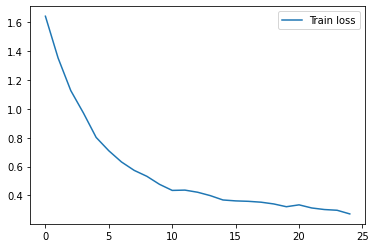

In [5]:
plt.figure(figsize=(6,4))
plt.plot(train_loss, label='Train loss')
# plt.plot(valid_loss, label='Valid loss')
plt.legend()

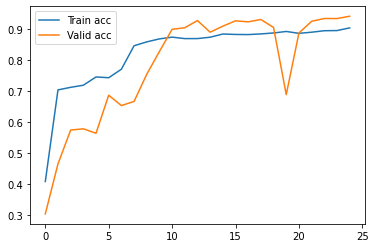

In [6]:
plt.figure(figsize=(6,4))
plt.plot(train_acc, label='Train acc')
plt.plot(valid_acc, label='Valid acc')
plt.legend()

# 4. Predict on test set

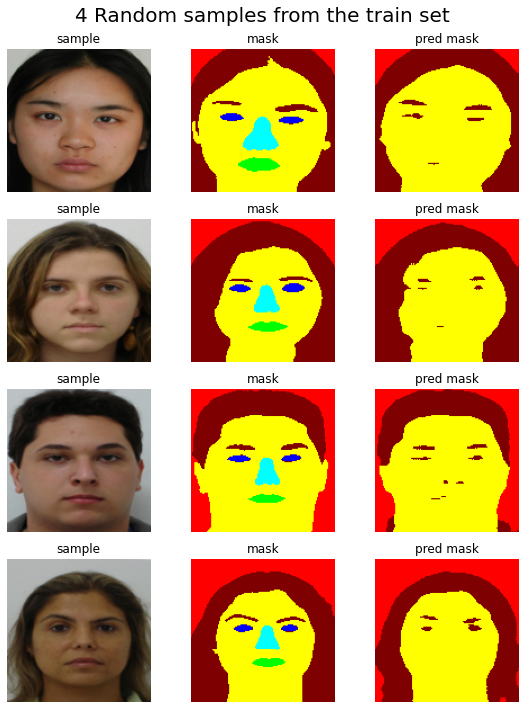

In [9]:
loader = trainloader
x_batch, y_batch = next(iter(loader))
y_pred_batch = unet(x_batch)
y_pred_batch = y_pred_batch.argmax(1).detach()

to_plot = 4
fig, axes = plt.subplots(nrows=to_plot, ncols=3, figsize=(8,10))

for i in range(to_plot):
    mask = label2mask(y_batch[i].numpy(), COLOR_MAP)
    pred_mask = label2mask(y_pred_batch[i].numpy(), COLOR_MAP)
    img = x_batch[i].permute(1, 2, 0).numpy()
    
    axes[i,0].axis("off")
    axes[i,0].set_title("sample")
    axes[i,0].imshow(img.astype('uint8'))
    
    axes[i,1].axis("off")
    axes[i,1].set_title("mask")
    axes[i,1].imshow(mask.astype('uint8'))
    
    axes[i,2].axis("off")
    axes[i,2].set_title("pred mask")
    axes[i,2].imshow(pred_mask.astype('uint8'))

fig.suptitle(f"{to_plot} Random samples from the train set", fontsize=20)     
fig.tight_layout()

In [ ]:
dd